# Experiments with Tesseract-OCR

### Tesseract Manual

#### Tesseract Manual 
```
Usage:
  tesseract --help | --help-extra | --help-psm | --help-oem | --version
  tesseract --list-langs [--tessdata-dir PATH]
  tesseract --print-fonts-table [options...] [configfile...]
  tesseract --print-parameters [options...] [configfile...]
  tesseract imagename|imagelist|stdin outputbase|stdout [options...] [configfile...]

OCR options:
  --tessdata-dir PATH   Specify the location of tessdata path.
  --user-words PATH     Specify the location of user words file.
  --user-patterns PATH  Specify the location of user patterns file.
  --dpi VALUE           Specify DPI for input image.
  --loglevel LEVEL      Specify logging level. LEVEL can be
                        ALL, TRACE, DEBUG, INFO, WARN, ERROR, FATAL or OFF.
  -l LANG[+LANG]        Specify language(s) used for OCR.
  -c VAR=VALUE          Set value for config variables.
                        Multiple -c arguments are allowed.
  --psm NUM             Specify page segmentation mode.
  --oem NUM             Specify OCR Engine mode.
NOTE: These options must occur before any configfile.

Page segmentation modes:
  0    Orientation and script detection (OSD) only.
  1    Automatic page segmentation with OSD.
  2    Automatic page segmentation, but no OSD, or OCR. (not implemented)
  3    Fully automatic page segmentation, but no OSD. (Default)
  4    Assume a single column of text of variable sizes.
  5    Assume a single uniform block of vertically aligned text.
  6    Assume a single uniform block of text.
  7    Treat the image as a single text line.
  8    Treat the image as a single word.
  9    Treat the image as a single word in a circle.
 10    Treat the image as a single character.
 11    Sparse text. Find as much text as possible in no particular order.
 12    Sparse text with OSD.
 13    Raw line. Treat the image as a single text line,
       bypassing hacks that are Tesseract-specific.

OCR Engine modes:
  0    Legacy engine only.
  1    Neural nets LSTM engine only.
  2    Legacy + LSTM engines.
  3    Default, based on what is available.

Single options:
  -h, --help            Show minimal help message.
  --help-extra          Show extra help for advanced users.
  --help-psm            Show page segmentation modes.
  --help-oem            Show OCR Engine modes.
  -v, --version         Show version information.
  --list-langs          List available languages for tesseract engine.
  --print-fonts-table   Print tesseract fonts table.
  --print-parameters    Print tesseract parameters.
```

Examples of using pytesseract:
```
pytesseract.image_to_string(Image.open("./imagesStackoverflow/xyz-small-gray.png"),
                                  lang="eng",boxes=False,
                                  config="--psm 4 --oem 3 
                                  -c tessedit_char_whitelist=-01234567890XYZ:"))
```

#### Notes on Tesseract 4.x and older
Tesseract 4.x and older uses DARK TEXT on LIGHT BACKGROUND

DO NOT rely on the interal binarization of Tesseract

Dilation & Erosion is helpful as preprocessing

Handle rotation / deskewing

ADD BORDERS (< 10px) to images before feeding the Tesseract

Input images MUST NOT contain transparency (as in png)

#### Meaning of image_to_data output:

```
level = 1/2/3/4/5，the level of current item.

page_num: the page index of the current item. In most instances, a image only has one page.

1. a page
2. a block
3. a paragraph
4. a line
5. a word.

block_num: the block item of the current item. when tesseract OCR Image, it will split the image into several blocks according the PSM parameters and some rules. The words in a line often in a block.

par_num: The paragraph index of the current item. It is the page analysis results. line_num: The line index of the current item. It is the page analysis results. word_num: The word index in one block.

line_num: The line index of the current item. It is the page analysis results.

word_num: The word index in one block.

left/top/width/height：the top-left coordinate and the width and height of the current word.

conf: the confidence of the current word, the range is -1~100.. The -1 means that there is no text here. The 100 is the highest value.

text: the word ocr results.
```

#### Meaning of image_to_osd output:
```
Page number: the page index of the current item. In most instances, a image only has one page.

Orientation in degrees: the clockwise rotation angle of the text in the current image relative to its reading angle, the value range is [0, 270, 180, 90].

Rotate: Record the angle at which the text in the current image is to be converted into readable, relative to the clockwise rotation of the current image, the value range is [0, 270, 180, 90]. Complementary to the [Orientation in degrees] value.

Orientation confidence:Indicates the confidence of the current [Orientation in degrees] and [Rotate] detection values. The greater the confidence, the more credible the test result, but no explanation of its value range has been found so far.

Script: The encoding type of the text in the current picture.

Script confidence: The confidence of the text encoding type in the current image.
```

### SETUP

In [2]:
import sys
import os

CWD="/workspaces/ocr-api-backend"

sys.path.append(CWD)

In [3]:
import pytesseract

TESSERACT_PATH="/usr/bin/tesseract"

DATA_DIRECTORY=os.path.join(CWD, "client/data")

pytesseract.pytesseract.tesseract_cmd=TESSERACT_PATH

In [4]:
# image = Image.open(os.path.join(DATA_DIRECTORY, "media02.png"))

# metadata = pytesseract.image_to_data(
#     image, lang=lang.eng_fast.name, config="--psm 6", output_type="dict"
# )

def plot_box(metadata, image):
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches

    fig, ax = plt.subplots()

    ax.imshow(image, cmap='gray')

    for i in range(len(metadata["level"])):
        (x, y, w, h) = (
            metadata["left"][i],
            metadata["top"][i],
            metadata["width"][i],
            metadata["height"][i],
        )

        rect = patches.Rectangle((x,y), w, h, linewidth=1, edgecolor='blue', facecolor='none')
        ax.add_patch(rect)

    plt.show()


### Experiments

#### Proposals

This section describes the experiments with several proposed image processing pipelines as potential solutions to our domain problem.

##### Proposal 22/01

<img src="./assets/2201-architecture.jpg" alt="2201-architecture" style="width: 500px"></img>

Expected input: screenshots

In [5]:
"""For counting running time of each module"""

import time


class Clock:
    def start(self):
        self.prev = time.time()

    def stop(self):
        self.now = time.time()

        print("Time elapsed: {}s".format(round(self.now - self.prev, 5)))


clock = Clock()

In [6]:
"""Load

Load all images onto the main memory
at once and return a list of loaded images.

COULD BE VULNERABLE IF RAM IS SMALL.
Always check `$ docker stats`
"""

from PIL import Image
import numpy as np
import os

ACCEPTED_IMG_EXT = ["png", "jpg"]


def load_images(image_repo, n_image=1):
    img_lst = os.listdir(image_repo)
    img_lst = list(
        filter(lambda file: file.split(".")[-1] in ACCEPTED_IMG_EXT, img_lst)
    )

    return [
        np.array(Image.open(os.path.join(image_repo, img)).convert('L'))
        for idx, img in zip(range(len(img_lst)), img_lst)
        if idx < n_image
    ]  # all images on RAM

clock.start()

img_lst = load_images(os.path.join(CWD, "client/data"), 5)

clock.stop()

Time elapsed: 0.1154s


gkajdsgk <class 'numpy.ndarray'>


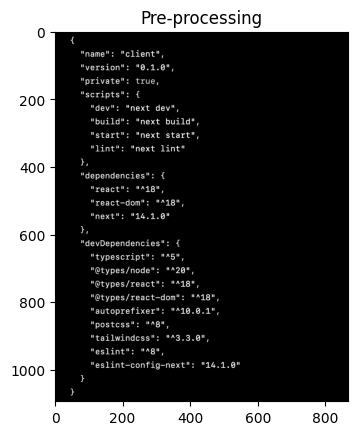

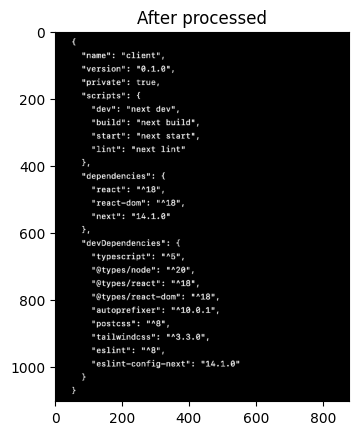

In [9]:
"""Preprocessing
"""

import cv2 as cv
import matplotlib.pyplot as plt
import app.modules.ocr.preprocess as preprocess


src = img_lst[3]

print("gkajdsgk", type(src))


# Plotting pre-processed image
original = plt.figure(1)
plt.title("Pre-processing")
plt.imshow(src, cmap="gray")


img = preprocess.binarize(src)
img = preprocess.add_border(img)


# Plotting after-processing image
processed = plt.figure(2)
plt.title("After processed")
plt.imshow(img, cmap="gray")

In [10]:
"""Tesseract
"""

from app.modules.ocr.tesseract import lang
from app.modules.ocr.tesseract.engine import TesseractOCR


def extract_text_from(image) -> str:
    """
    Extract raw text
    """
    return pytesseract.image_to_string(image, lang=lang.eng_fast.name, config="--psm 6")


def extract_data_from(image) -> dict:
    """
    Extract metadata of textual information from the image
    """
    return pytesseract.image_to_data(
        image, lang=lang.eng_fast.name, config="--psm 6", output_type="data.frame"
    )

string = extract_text_from(img)
print(string)
plot_box(extract_data_from(img), img)

data = extract_data_from(img)

In [17]:
"""Evaluates confidence
"""

import json
from pandas import DataFrame as df


def keep_text_from(data: df, lowest_conf: float = 20.0):
    """
    Filter the metadata any detected tokens lower than the lowest_conf
    """
    data = data.drop(data[data.conf <= lowest_conf].index)
    return data


print(len(data))
text_data = keep_text_from(data)
print(len(text_data))

print(text_data)

95
51
    level  page_num  block_num  par_num  line_num  word_num  left   top  \
4       5         1          1        1         1         1    52    22   
7       5         1          1        2         1         1    82    64   
8       5         1          1        2         1         2   201    61   
11      5         1          1        3         1         1    82   101   
12      5         1          1        3         1         2   246   103   
15      5         1          1        4         1         1    82   142   
16      5         1          1        4         1         2   244   145   
19      5         1          1        5         1         1    82   181   
20      5         1          1        5         1         2   245   182   
23      5         1          1        6         1         1   112   223   
24      5         1          1        6         1         2   216   224   
25      5         1          1        6         1         3   303   223   
27      5         1

In [ ]:
"""Static word fixing
"""

def correct_text(data: df):
    pass

In [ ]:
"""Final output

Depends on how you design the API.

Ask yourself what you want to return to the front-end:
- returns tokens by tokens
    - this could be useful when many tokens are wrongly detected
    - we can send to the front-end correct tokens first (high confidence),
    meanwhile on the server we try to correct the wrong tokens 
    (static word fixing) and send the tokens later.
- return entire text
    - i am not sure this is a good idea
"""

def dont_know_yet():
    pass

# For now i just concatenate every tokens into one single string
def to_single_string(dataframe):
    print(dataframe["text"])